## 사용 패키지

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'

# from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb



# `0704 추가`

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [4]:
# HYPER PARAMETERS

class CFG:
    emb_dim = 200

args = CFG

df_train = pd.read_csv('G:\내 드라이브\Github\Dacon_Prediction-of-number-AI/train.csv')
df_test = pd.read_csv('G:\내 드라이브\Github\Dacon_Prediction-of-number-AI/test.csv')

#word embedding

df_all = pd.concat([df_train, df_test]) ## 여기 임의수정. df -> df.train

# Basic text preprocessing

def split_process(x, q):
    x_ = []
    x = x.split(' ')
    for i in x:
        if '(' in i and ':' in i and ')' in i:
            continue
        if '/' in i:
            x_.extend(i.split('/'))
        else:
            x_.append(i)
    x_ = list(set(x_))
    x_.remove('')
    return x_

# Get all combinations for training w2v (train + test)

food_combinations = []
for i in ['조식메뉴', '중식메뉴', '석식메뉴']:
    food_combinations += df_all[i].apply(lambda x: split_process(x, i)).to_list()
    
# Train or load w2v model

TRAIN_W2V = True
try:
    model = Word2Vec.load('food_embedding.model')
    print("Model loaded")
except:
    if TRAIN_W2V:
        print("Training w2v")
        model = Word2Vec(sentences=food_combinations, vector_size=args.emb_dim, window=7, min_count=0, workers=4, sg=0, epochs=5000)
        model.save('food_embedding.model')
    else:
        print("Model loading failed. Do not train.")
        
# w2v demo
model.wv.most_similar('된장찌개')

Training w2v


TypeError: __init__() got an unexpected keyword argument 'vector_size'

process

In [ ]:
def process_date(df):
    df['일자'] = pd.to_datetime(df['일자'], format="%Y-%m-%d")
    df['year'] = df['일자'].dt.year
    df['month'] = df['일자'].dt.month
    df['day'] = df['일자'].dt.day
    df = df.drop('일자', axis=1)
    return df

In [ ]:
def get_food_embedding(x):
    x_ = []
    x = x.split(' ')
    for i in x:
        if '(' in i and ':' in i and ')' in i:
            continue
        if '/' in i:
            x_.extend(i.split('/'))
        else:
            x_.append(i)
    x_ = list(set(x_))
    x_.remove('')
    vec_ = np.zeros(args.emb_dim)
    for i in x_:
        vec = model.wv.get_vector(i)
        vec_ += vec
    vec_ /= len(x_)
    return vec_

# General preprocessing
df_train = process_date(df_train)
day_encoder = LabelEncoder()
df_train['요일'] = day_encoder.fit_transform(df_train['요일'])

# Get embedding
df_train['조식메뉴_embedding'] = df_train['조식메뉴'].apply(lambda x: get_food_embedding(x))
df_train['중식메뉴_embedding'] = df_train['중식메뉴'].apply(lambda x: get_food_embedding(x))
df_train['석식메뉴_embedding'] = df_train['석식메뉴'].apply(lambda x: get_food_embedding(x))

y_lunch = df_train['중식계']
y_dinner = df_train['석식계']
df_train.drop(['조식메뉴', '중식메뉴', '석식메뉴', '중식계', '석식계'], axis=1, inplace=True)

X_common = df_train.iloc[:, :9]

# emb_arr_lunch = np.array(df_train.iloc[:, 9].to_numpy().tolist()) + np.array(df_train.iloc[:, 10].to_numpy().tolist()) # Ver 1
# emb_arr_dinner = np.array(df_train.iloc[:, 9].to_numpy().tolist()) + np.array(df_train.iloc[:, 11].to_numpy().tolist()) # Ver 1
emb_arr_lunch = np.array(df_train.iloc[:, 10].to_numpy().tolist()) # Ver 2
emb_arr_dinner = np.array(df_train.iloc[:, 11].to_numpy().tolist()) # Ver 2

X_train_lunch = np.concatenate((X_common.to_numpy(), emb_arr_lunch), axis=1)
X_train_dinner = np.concatenate((X_common.to_numpy(), emb_arr_dinner), axis=1)

X_train_lunch, X_test_lunch, y_train_lunch, y_test_lunch = train_test_split(X_train_lunch, y_lunch, test_size=0.1, random_state=42)
X_train_dinner, X_test_dinner, y_train_dinner, y_test_dinner = train_test_split(X_train_dinner, y_dinner, test_size=0.1, random_state=42)

# Simple LGBM Regressor w/o tuning
model_lunch = LGBMRegressor()
model_lunch.fit(X_train_lunch, y_train_lunch)

model_dinner = LGBMRegressor()
model_dinner.fit(X_train_dinner, y_train_dinner)

# Validate
pred_lunch = model_lunch.predict(X_test_lunch)
pred_dinner = model_dinner.predict(X_test_dinner)

print("lunch mae: ", mean_absolute_error(y_test_lunch, pred_lunch))
print("dinner mae: ", mean_absolute_error(y_test_dinner, pred_dinner))

inference

In [ ]:
df_test = pd.read_csv('G:\내 드라이브\Github\Dacon_Prediction-of-number-AI/test.csv')

# Apply general preprocessing
df_test= process_date(df_test)
df_test['요일'] = day_encoder.transform(df_test['요일'])
df_test['조식메뉴_embedding'] = df_test['조식메뉴'].apply(lambda x: get_food_embedding(x))
df_test['중식메뉴_embedding'] = df_test['중식메뉴'].apply(lambda x: get_food_embedding(x))
df_test['석식메뉴_embedding'] = df_test['석식메뉴'].apply(lambda x: get_food_embedding(x))
df_test.drop(['조식메뉴', '중식메뉴', '석식메뉴'], axis=1, inplace=True)
X_test_common = df_test.iloc[:, :9]

emb_arr_lunch = np.array(df_train.iloc[:, 10].to_numpy().tolist()) # Ver 2
emb_arr_dinner = np.array(df_train.iloc[:, 11].to_numpy().tolist()) # Ver 2

# Get embedding
test_emb_arr_lunch = np.array(df_test.iloc[:, 10].to_numpy().tolist()) # Ver 2
test_emb_arr_dinner = np.array(df_test.iloc[:, 11].to_numpy().tolist()) # Ver 2
# Concat
test_lunch = np.concatenate((X_test_common.to_numpy(), test_emb_arr_lunch), axis=1)
test_dinner = np.concatenate((X_test_common.to_numpy(), test_emb_arr_dinner), axis=1)

# Inference

test_pred_lunch = model_lunch.predict(test_lunch)
test_pred_dinner = model_dinner.predict(test_dinner)

submission_df = pd.read_csv('G:\내 드라이브\Github\Dacon_Prediction-of-number-AI/test.csv')
submission_df['중식계'] = test_pred_lunch
submission_df['석식계'] = test_pred_dinner

# Save

submission_df.to_csv('sub_2.csv', index=False)

---

## 데이터 로드

In [2]:
train = pd.read_csv('G:\내 드라이브\Github\Dacon_Prediction-of-number-AI/train.csv')
test = pd.read_csv('G:\내 드라이브\Github\Dacon_Prediction-of-number-AI/test.csv')
submission = pd.read_csv('G:\내 드라이브\Github\Dacon_Prediction-of-number-AI/sample_submission.csv')

## 데이터

In [3]:
train.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0
2,2016-02-03,수,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0
3,2016-02-04,목,2601,104,220,355,0.0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978.0,525.0
4,2016-02-05,금,2601,278,181,34,0.0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925.0,330.0


In [111]:
test.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,년,월,일,주,식사가능자수
0,2021-01-27,3,2983,88,182,5,358.0,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치,2021,1,27,4,2537.0
1,2021-01-28,4,2983,104,212,409,348.0,모닝롤/대만샌드위치 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 황태국 시래기지짐 ...,쌀밥/보리밥/찰현미밥 우렁된장찌개 오리주물럭 청양부추전 수제삼색무쌈 겉절이김치 양상...,충무김밥 우동국물 오징어무침 꽃맛살샐러드 얼갈이쌈장무침 석박지,2021,1,28,4,2531.0
2,2021-01-29,5,2983,270,249,0,294.0,모닝롤/핫케익 우유/주스 계란후라이/찐계란 오곡죽/흑미밥 매생이굴국 고구마순볶음 양...,쌀밥/흑미밥/찰현미밥 팽이장국 수제돈까스*소스 가자미조림 동초나물무침 포기김치 양상...,흑미밥 물만둣국 카레찜닭 숯불양념꼬지어묵 꼬시래기무침 포기김치,2021,1,29,4,2419.0
3,2021-02-01,1,2924,108,154,538,322.0,모닝롤/촉촉한치즈케익 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 두부김칫국 새우완...,쌀밥/흑미밥/찰현미밥 배추들깨국 오리대패불고기 시금치프리타타 부추고추장무침 포기김치...,흑미밥 동태탕 돈육꽈리고추장조림 당면채소무침 모자반무침 포기김치,2021,2,1,5,2494.0
4,2021-02-02,2,2924,62,186,455,314.0,모닝롤/토마토샌드 우유/주스 계란후라이/찐계란 채소죽/흑미밥 호박맑은국 오이생채 양...,쌀밥/팥밥/찰현미밥 부대찌개 닭살데리야끼조림 버섯탕수 세발나물무침 알타리김치/사과푸...,흑미밥 바지락살국 쇠고기청경채볶음 두부구이*볶은김치 머위된장무침 백김치,2021,2,2,5,2548.0


In [112]:
submission.head()

,일자,중식계,석식계
0,2021-01-27,922.126896,223.256931
1,2021-01-28,858.650822,441.713272
2,2021-01-29,580.763474,311.119382
3,2021-02-01,1279.065836,562.560220
4,2021-02-02,1107.612456,489.883492


In [113]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   일자              1205 non-null   datetime64[ns]
 1   요일              1205 non-null   int64         
 2   본사정원수           1205 non-null   int64         
 3   본사휴가자수          1205 non-null   int64         
 4   본사출장자수          1205 non-null   int64         
 5   본사시간외근무명령서승인건수  1205 non-null   int64         
 6   현본사소속재택근무자수     1205 non-null   float64       
 7   조식메뉴            1205 non-null   object        
 8   중식메뉴            1205 non-null   object        
 9   석식메뉴            1205 non-null   object        
 10  중식계             1205 non-null   float64       
 11  석식계             1205 non-null   float64       
 12  년               1205 non-null   int64         
 13  월               1205 non-null   int64         
 14  일               1205 non-null   int64         
 15  주   

In [114]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   일자              50 non-null     datetime64[ns]
 1   요일              50 non-null     int64         
 2   본사정원수           50 non-null     int64         
 3   본사휴가자수          50 non-null     int64         
 4   본사출장자수          50 non-null     int64         
 5   본사시간외근무명령서승인건수  50 non-null     int64         
 6   현본사소속재택근무자수     50 non-null     float64       
 7   조식메뉴            50 non-null     object        
 8   중식메뉴            50 non-null     object        
 9   석식메뉴            50 non-null     object        
 10  년               50 non-null     int64         
 11  월               50 non-null     int64         
 12  일               50 non-null     int64         
 13  주               50 non-null     int32         
 14  식사가능자수          50 non-null     float64       
dtypes: datet

In [115]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   일자      50 non-null     object 
 1   중식계     50 non-null     float64
 2   석식계     50 non-null     float64
dtypes: float64(2), object(1)
memory usage: 1.3+ KB


## 요일을 숫자로 매핑

In [116]:
train['요일'] = train['요일'].map({'월':1, '화':2, '수':3, '목':4, '금':5})
test['요일'] = test['요일'].map({'월':1, '화':2, '수':3, '목':4, '금':5})

## `월, 일을 숫자형으로 변환`

In [117]:
train['일자'] = pd.to_datetime(train['일자'])
test['일자'] = pd.to_datetime(test['일자'])

print(train['일자'])

train['년'] = train['일자'].dt.year
train['월'] = train['일자'].dt.month
train['일'] = train['일자'].dt.day
train['주'] = train['일자'].dt.isocalendar().week

test['년'] = test['일자'].dt.year
test['월'] = test['일자'].dt.month
test['일'] = test['일자'].dt.day
test['주'] = test['일자'].dt.isocalendar().week

0      2016-02-01
1      2016-02-02
2      2016-02-03
3      2016-02-04
4      2016-02-05
          ...    
1200   2021-01-20
1201   2021-01-21
1202   2021-01-22
1203   2021-01-25
1204   2021-01-26
Name: 일자, Length: 1205, dtype: datetime64[ns]


## `식사가능자수 , 식사참여율`

In [118]:
train['식사가능자수'] = train['본사정원수'] - train['본사휴가자수'] - train['현본사소속재택근무자수']
test['식사가능자수'] = test['본사정원수'] - test['본사휴가자수'] - test['현본사소속재택근무자수']

In [119]:
#train['중식참여율'] = train['중식계'] / train['식사가능자수']
#train['석식참여율'] = train['석식계'] / train['식사가능자수']

#test['중식참여율'] = test['중식계'] / test['식사가능자수']
#test['석식참여율'] = test['석식계'] / test['식사가능자수']

## 수치 데이터만 피쳐로 선택

In [120]:
#x_train = train[['요일', '본사정원수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수']]
#y1_train = train['중식계']
#y2_train = train['석식계']

#x_test = test[['요일', '본사정원수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수']]

In [121]:
train['주'] = train['주'].astype('int') # '주'의 타입이 Uint로 사용이 안되어 int로 변경해줌.
test['주'] = test['주'].astype('int')

In [131]:
x1_train = train[['요일', '본사시간외근무명령서승인건수', '식사가능자수','월', '일','년']] #중식계
x2_train = train[['요일', '본사시간외근무명령서승인건수', '식사가능자수','월', '일','년']] #석식계


y1_train = train['중식계']
y2_train = train['석식계']

x_test = test[['요일', '본사시간외근무명령서승인건수', '식사가능자수', '월', '일','년']]

<AxesSubplot:>

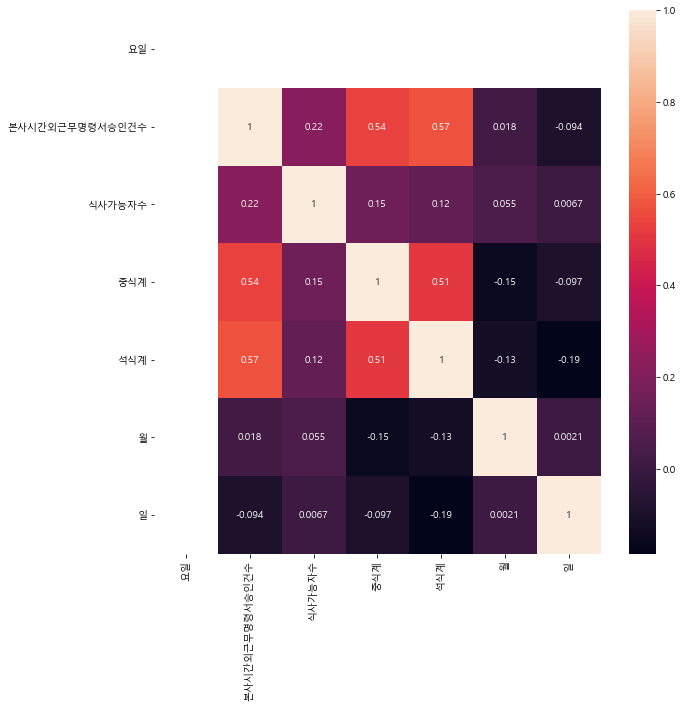

In [132]:
check = train[['요일', '본사시간외근무명령서승인건수', '식사가능자수', '중식계', '석식계', '월', '일']]

plt.figure(figsize=(10,10)) # 도화지 크기를 키워줌
sns.heatmap(check.corr(), annot = True) # seaborn의 heatmap 함수에 train.corr() 상관계수를 넣어준다.
                                        # annot < 수치도 같이 나타내줌

## 점심과 저녁을 식수 인원을 예측할 2개 모델 생성

In [133]:
model1 = lgb.LGBMRegressor(random_state=42, n_estimators = 1000)
model2 = lgb.LGBMRegressor(random_state=42, n_estimators = 1000)

## 학습

In [134]:
model1.fit(x1_train, y1_train) #중식계
model2.fit(x2_train, y2_train) #석식계

LGBMRegressor(n_estimators=1000, random_state=42)

In [135]:
from sklearn.model_selection import KFold

In [136]:
k_fold = KFold(n_splits = 5, shuffle = True, random_state = 777)

In [137]:
model1 = lgb.LGBMRegressor(random_state = 777, n_estimators = 1000)

models1 = [] # 교차검증을 위한 바구나 5개

for train_idx, val_idx in k_fold.split(x1_train):
    x1_t = x1_train.iloc[train_idx]
    y1_t = y1_train.iloc[train_idx]
    x1_val = x1_train.iloc[val_idx]
    y1_val = y1_train.iloc[val_idx]
    
    models1.append(model1.fit(x1_t, y1_t, eval_set = (x1_val, y1_val), early_stopping_rounds=100, verbose = 100))
    
model2 = lgb.LGBMRegressor(random_state = 777, n_estimators = 1000)

models2 = [] # 교차검증을 위한 바구나 5개

for train_idx, val_idx in k_fold.split(x2_train):
    x2_t = x2_train.iloc[train_idx]
    y2_t = y2_train.iloc[train_idx]
    x2_val = x2_train.iloc[val_idx]
    y2_val = y2_train.iloc[val_idx]
    
    models2.append(model2.fit(x2_t, y2_t, eval_set = (x2_val, y2_val), early_stopping_rounds=100, verbose = 100))

Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 23138.5
Early stopping, best iteration is:
[43]	valid_0's l2: 22625.9
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 19812.2
Early stopping, best iteration is:
[46]	valid_0's l2: 18713.1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 22763.8
Early stopping, best iteration is:
[38]	valid_0's l2: 21269.2
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 22388.4
Early stopping, best iteration is:
[41]	valid_0's l2: 21206.3
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 20764
Early stopping, best iteration is:
[37]	valid_0's l2: 19109.7
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 6393.61
Early stopping, best iteration is:
[55]	valid_0's l2: 6195.89
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 7917.67


In [138]:
preds1 = []
for model1 in models1:
    preds1.append(model1.predict(x_test))
    
preds2 = []
for model2 in models2:
    preds2.append(model2.predict(x_test))

pred1 = np.mean(preds1, axis=0)
pred2 = np.mean(preds2, axis=0)

## 추론

In [139]:
submission['중식계'] = pred1
submission['석식계'] = pred2

## 결과 제출

In [140]:
submission.to_csv('LGBMy.csv', index=False)

In [60]:
# 여태까지 최고성적은 요일, 일, 월만 추가한 것이었음.